# User Stories
List User Stories, that does not have a valid Acceptance Criteria

## Prerequistes

First you need to create an `.env`file in the root of your project folder

The format should be like this:

```
ORG = 'Your Organisation'
PRJ = 'Your Project'
PAT = 'Your Personal Access Token'
````

The first information you can find here eg.:

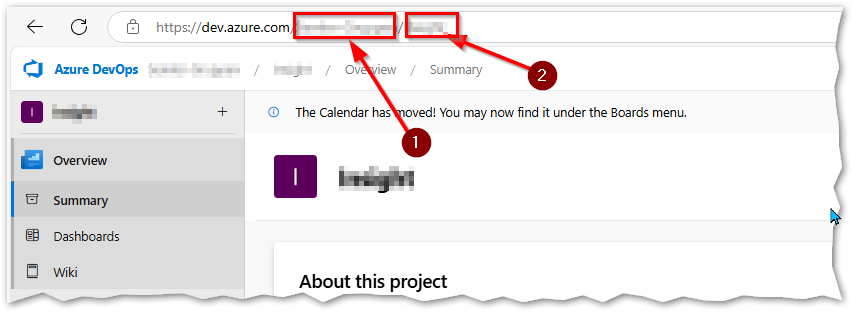

The Personal Access Token you need to create yourself:
1. Click on `User Settings`
2. Click on `Personal Access Token`

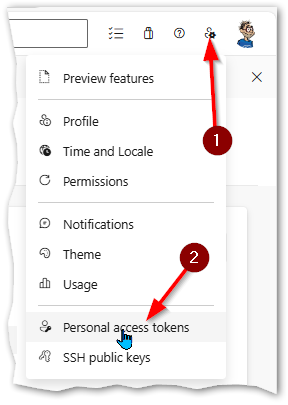

Then click on new token, give it a name, set duration, and for simplicity, set Scope to full access, and hit `Create`.

Then make a note of the key, and add it to your `.env` file.



## The Code
Here the assumption is, that you know how to import the needed libraries

The code here below, uses the information saved in the `.env` file, to log on to DevOps and finds the user stories as defined in the section `# Define conditions`

You can play arround with these definitions in the section `# Combine conditions`

In [ ]:
import httpx
import os
import json
from dotenv import load_dotenv
from httpx import BasicAuth
import pandas as pd

# Load environment variables
load_dotenv()

organization = os.getenv('ORG')
project = os.getenv('PRJ')
personal_access_token = os.getenv('PAT')

# Define WIQL to fetch User Stories
wiql_query = {
    "query": "SELECT [System.Id], [System.Title], [System.State], [System.AssignedTo], [System.IterationPath] FROM WorkItems WHERE [System.WorkItemType] = 'User Story'"
}

# API endpoint for executing the WIQL query
url = f"https://dev.azure.com/{organization}/{project}/_apis/wit/wiql?api-version=7.1"

# Define the headers
headers = {
    'Content-Type': 'application/json'
}

# Execute the WIQL query
response = httpx.post(url, headers=headers, json=wiql_query, auth=BasicAuth('', personal_access_token))

# Check response
if response.status_code == 200:
    try:
        response_json = response.json()
        work_item_ids = [item['id'] for item in response_json['workItems']]
        batch_size = 100
        user_stories = []

        # Loop over batches
        for i in range(0, len(work_item_ids), batch_size):
            batch_ids = work_item_ids[i:i + batch_size]

            # Fetch details of each work item batch
            work_items_details_url = f"https://dev.azure.com/{organization}/{project}/_apis/wit/workitems?ids={','.join(map(str, batch_ids))}&api-version=7.1"
            details_response = httpx.get(work_items_details_url, headers=headers, auth=BasicAuth('', personal_access_token))

            if details_response.status_code == 200:
                work_items_data = details_response.json()['value']

                for item in work_items_data:
                    fields = item['fields']
                    work_item_id = item['id']
                    
                    # Build URL for the work item
                    work_item_url = f"https://dev.azure.com/{organization}/{project}/_workitems/edit/{work_item_id}"

                    user_story = {
                        'ID': work_item_id,
                        'Title': fields.get('System.Title'),
                        'State': fields.get('System.State'),
                        'AssignedTo': fields.get('System.AssignedTo', {}).get('displayName', 'Unassigned'),
                        'IterationPath': fields.get('System.IterationPath'),
                        'AcceptanceCriteria': 'Yes' if fields.get('Microsoft.VSTS.Common.AcceptanceCriteria') else 'No',
                        'PlanningState': fields.get('Custom.PlanningState'),
                        'url': work_item_url  # Store URL separately if needed
                    }
                    user_stories.append(user_story)
            else:
                print(f"Error fetching work item details: {details_response.status_code}")

    except json.JSONDecodeError:
        print(f"Error decoding JSON response: {response.text}")
else:
    print(f"Error executing WIQL query: {response.status_code} - {response.text}")


UserStories = pd.DataFrame(user_stories)

# Define conditions
iteration_path_condition = UserStories['IterationPath'].str.contains('Insight')
planning_state_condition = UserStories['PlanningState'].str.contains('Ready for Sprint', na=False)
acceptance_criteria_condition = UserStories['AcceptanceCriteria'] == 'No'
state_condition = ~UserStories['State'].isin(['Closed', 'Removed'])

# Combine conditions
combined_conditions = (
    iteration_path_condition &
    planning_state_condition &
    acceptance_criteria_condition &
    state_condition
)

# Filtrer DataFrame
filtered_df = UserStories[combined_conditions]

### Print the the result in a nice format
Here we use `Markdown` from the library `IPython.display` to nicely format the output in Markdown, for nicer reading in this workbook

In [ ]:
# Importer det nødvendige bibliotek til Markdown
from IPython.display import Markdown, display

# Funktion for at konvertere DataFrame til Markdown med hyperlinks i Title kolonnen
def print_markdown_with_links(df):
    df = df.copy()  # For at undgå at ændre originalen
    # Lav hyperlink til hver titel
    df['Title'] = df.apply(lambda x: f"[{x['Title']}]({x['url']})", axis=1)
    # Vælg kun de kolonner, som du vil vise
    df = df[['ID','Title', 'State', 'AssignedTo', 'IterationPath', 'PlanningState']] 
    # Generer Markdown
    md = df.to_markdown(index=False)
    display(Markdown(md))

# Brug funktionen til at printe DataFrame som Markdown med hyperlinks
print_markdown_with_links(filtered_df)